# <font color='green'>**High Growth Restaurants in Manhattan**</font>

For this project we will look to explore growth trends within [Restaurant Business Online's future 50 restaurants.](https://www.restaurantbusinessonline.com/future-50-2020)  We will use Foursquare location data to see if there are any similar patterns or trends in where these restaurants are located, and use the information to find the best place for us to open a new high volume cafe in Manhattan. 

Table of Contents  
1.) data cleaning    
 2.) EDA  
 3.) clustering  
 4.) results  
 

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import requests
from pandas.io.json import json_normalize


import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

from sklearn.cluster import KMeans

! pip install folium==0.5.0
import folium
print('Folium Installed!')

     |████████████████████████████████| 79 kB 8.8 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=f99b511301a1aaf050b3a422505128901d0a2e69635835a888ea08fc1e921db0
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Folium Installed!


In [2]:
# The code was removed by Watson Studio for sharing.

,Rank,Restaurant,Location,Sales,YOY_Sales,Units,YOY_Units,Unit_Volume,Franchising
0,1,Evergreens,"Seattle, Wash.",24,130.5%,26,116.7%,1150,No
1,2,Clean Juice,"Charlotte, N.C.",44,121.9%,105,94.4%,560,Yes
2,3,Slapfish,"Huntington Beach, Calif.",21,81.0%,21,90.9%,1370,Yes
3,4,Clean Eatz,"Wilmington, N.C.",25,79.7%,46,58.6%,685,Yes
4,5,Pokeworks,"Irvine, Calif.",49,77.1%,50,56.3%,1210,Yes


Description of dataset via Michal Bogacz on [kaggle](https://www.kaggle.com/michau96/restaurant-business-rankings-2020). 

Rank = Position in ranking  
Restaurant = Name of restaurant  
Location = Location of origin of the restaurant  
Sales = 2019 Systemwide Sales   	
YOY Sales = Year on year sales increase  	
Stores = Number of premises  	
'YOY Store Growth' = Year on year premises increase 	
Unit_Volume = 2019 Average Unit Volume ($000)   	
Franchising = Is the restaurant a franchise? (Y/N) 

In [3]:
df.shape

(50, 9)

In [4]:
df.dtypes

Rank            int64
Restaurant     object
Location       object
Sales           int64
YOY_Sales      object
Units           int64
YOY_Units      object
Unit_Volume     int64
Franchising    object
dtype: object

In [5]:
#changing percents to floats

df['YOY_Sales']=df['YOY_Sales'].apply(lambda x:x.replace('%',''))
df['YOY_Units']=df['YOY_Units'].apply(lambda x:x.replace('%',''))
#===
df['YOY_Sales']= pd.to_numeric(df['YOY_Sales'])
df['YOY_Units']=pd.to_numeric(df['YOY_Units'])

In [6]:
df = df.rename(columns={'Units' : 'Stores','YOY_Units' : 'YOY_Store_Growth'})


Let's get an idea for how many locations the restaurants on this list have: 

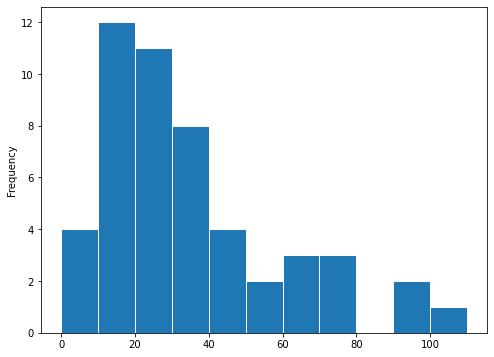

In [7]:
plt.figure(figsize=(8,6))
bins=[0,10,20,30,40,50,60,70,80,90,100,110]
df['Stores'].plot(kind='hist',bins=bins,edgecolor='w')

We can also take a closer look at what cities these stores are based in:

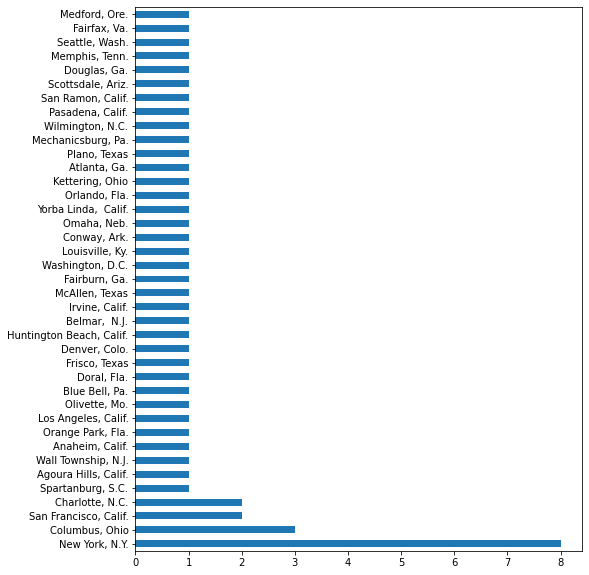

In [8]:
plt.figure(figsize=(8,10))
df['Location'].value_counts().plot(kind='barh')

Let's also take a look at how many of these stores on the list are franchises:

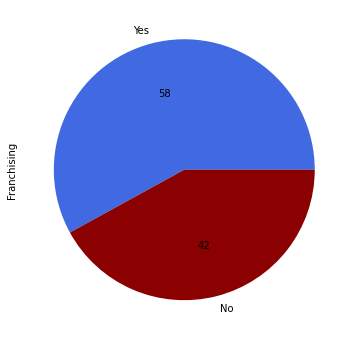

In [9]:
plt.figure(figsize=(6,6))

df['Franchising'].value_counts().plot(kind='pie',autopct='%.f',colors = ['royalblue','darkred'])
plt.show()

we can check and see if franchising has any correlation with the other numbers in our dataframe.

In [10]:
franchise_onehot = pd.get_dummies(df[['Franchising']], prefix="", prefix_sep="")
franchise_onehot = franchise_onehot.rename(columns={'Yes' : 'Franchise?'})
df['Franchise?'] = franchise_onehot['Franchise?']

we'll do the same with NYC locations and see if there is any correlation there as well.  

In [11]:
location_onehot = pd.get_dummies(df[['Location']], prefix="", prefix_sep="")
df['NYC'] = location_onehot['New York, N.Y.']


In [12]:
dfcorr = df[['Sales','YOY_Sales','YOY_Store_Growth','Unit_Volume','Franchise?','NYC','Stores']]

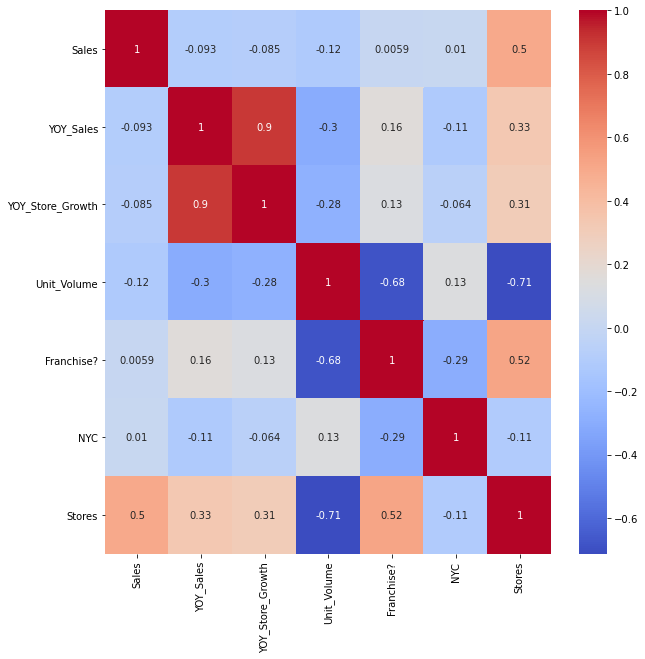

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(dfcorr.corr(), annot=True,cmap='coolwarm')

Nothing too surprising here. From this heatmap, you could say that franchises tend to have slightly more locations and do overall less volume per location.  It is pretty apparent that the more stores you have, the less volume you tend to do at your locations.  We're going to explore volume a but further, and focus our efforts around New York City, where we are planning to open our cafe.   

In [14]:
dfny = df[df.Location=="New York, N.Y."]
dfny = dfny.sort_values('Unit_Volume',ascending=False,ignore_index=True)
dfny

,Rank,Restaurant,Location,Sales,YOY_Sales,Stores,YOY_Store_Growth,Unit_Volume,Franchising,Franchise?,NYC
0,34,Boqueria,"New York, N.Y.",27,22.0,7,16.7,4260,No,0,1
1,25,By Chloe,"New York, N.Y.",37,25.6,14,7.7,2800,No,0,1
2,23,The Little Beet,"New York, N.Y.",23,26.5,12,33.3,2230,No,0,1
3,29,Dos Toros Taqueria,"New York, N.Y.",28,24.0,22,10.0,1375,No,0,1
4,8,Melt Shop,"New York, N.Y.",20,39.6,19,35.7,1260,Yes,1,1
5,32,Just Salad,"New York, N.Y.",42,22.7,38,26.7,1240,No,0,1
6,14,Bluestone Lane,"New York, N.Y.",48,33.0,48,37.1,1175,No,0,1
7,24,Joe & The Juice,"New York, N.Y.",47,25.9,69,25.5,760,Yes,1,1


In [15]:
#drop columns we won't be using
dfny = dfny[['Restaurant','Sales','YOY_Sales','Stores','YOY_Store_Growth','Unit_Volume','Franchise?']]

In [16]:
dfny =dfny.rename(columns={'Restaurant' : 'name'})

Let's incorporate the Foursquare location data and get a feel for where these places are located in New York City.  

In [17]:
# The code was removed by Watson Studio for sharing.

api ready


In [18]:
#Since we have no specified locations yet, we'll plug in the coordinates for New York City, and find locations from there.
NYC_lat = 40.7128
NYC_lng = -74.0060

We'll start by looking at the two other cafes on our list, Joe & the Juice and Bluestone Lane, they coincidentally have the lowest volume per location and highest amount of stores, but this could also be indicative of the products they are selling and not just location.

In [19]:
#function from the Training labs that extracts venue category from JSON file

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
search_query = 'Joe & The Juice'
LIMIT = 70 #There are 69 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Joe & The Juice&radius=10000&limit=70'

In [21]:
results = requests.get(url).json()

In [22]:
venues = results['response']['venues']
    
joes = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
joes =joes.loc[:, filtered_columns]

# filter the category for each row
joes['Type'] = joes.apply(get_category_type, axis=1)

# clean columns
joes.columns = [col.split(".")[-1] for col in joes.columns]

joes.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.715674,-74.010960,Juice Bar
1,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.722482,-73.997453,Juice Bar
2,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.712777,-74.013345,Juice Bar
3,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.705570,-74.008160,Juice Bar
4,JOE & THE JUICE,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",40.705941,-74.011644,Juice Bar


In [23]:
joes.shape

(50, 5)

Our search turned up 50 matching items within 10000 Meters of New York City.  
Let's see how many are Joe & the Juice Locations.

In [24]:
joes['name'].value_counts()

JOE & THE JUICE                                                       13
Joe Coffee Company                                                     6
Trader Joe's                                                           4
Joe Coffee                                                             3
Law Office of Joe Stancati                                             2
Joe D's Office                                                         1
Joe’s Pizza                                                            1
Joe and Sal's Pizza                                                    1
Joe DiMaggio Highway                                                   1
Joe Ginsberg Design                                                    1
Joe Pro Shop                                                           1
Joe Nachbaur - State Farm Insurance Agent                              1
Joe's Gourmet Duane                                                    1
Joe G Ristorante Italiano                          

We got 13 true matches.  We'll drop the other stores on our list and focus only on the Joe & the Juice locations.

In [25]:
JustJoes = joes[joes['name'].str.contains("JOE & THE JUICE")]
JustJoes = JustJoes[['name','lat','lng','Type']]
JustJoes

,name,lat,lng,Type
0,JOE & THE JUICE,40.715674,-74.010960,Juice Bar
1,JOE & THE JUICE,40.722482,-73.997453,Juice Bar
2,JOE & THE JUICE,40.712777,-74.013345,Juice Bar
3,JOE & THE JUICE,40.705570,-74.008160,Juice Bar
4,JOE & THE JUICE,40.705941,-74.011644,Juice Bar
6,JOE & THE JUICE,40.725983,-74.001298,Juice Bar
16,JOE & THE JUICE,40.762738,-73.977966,Juice Bar
23,JOE & THE JUICE,40.765877,-73.981975,Juice Bar
24,JOE & THE JUICE,40.754717,-73.982774,Juice Bar
33,JOE & THE JUICE,40.770128,-73.962422,Juice Bar


I'll rename the stores so they match our other dataframe.

In [26]:
JustJoes['name'] = JustJoes['name'].str.replace('JOE & THE JUICE','Joe & The Juice')


Now let's do the same for Bluestone Lane.

In [27]:
search_query = 'Bluestone Lane'
LIMIT = 50 #There are 48 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url2 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url2

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Bluestone Lane&radius=10000&limit=50'

In [28]:
results2 = requests.get(url2).json()

In [29]:
venues2 = results2['response']['venues']
    
bluestone = json_normalize(venues2) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
bluestone =bluestone.loc[:, filtered_columns]

# filter the category for each row
bluestone['Type'] = bluestone.apply(get_category_type, axis=1)

# clean columns
bluestone.columns = [col.split(".")[-1] for col in bluestone.columns]

bluestone.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.706268,-74.011687,Café
1,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.700880,-73.988060,Café
2,Bluestone Lane,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.730009,-74.002855,Café
3,Bluestone Lane,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",40.730104,-73.990307,Coffee Shop
4,Bluestone Lane Collective Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",40.735808,-74.000863,Café


In [30]:
bluestone.shape

(50, 5)

In [31]:
bluestone['name'].value_counts()

Bluestone Lane                                                                      20
Maiden Lane Medical                                                                  2
Lane Jewelers                                                                        1
Andrew Lavoott Bluestone                                                             1
Bluestone Café                                                                       1
Famous Famiglia Pizza - Maiden Lane                                                  1
Xpress Lane Pharmacy                                                                 1
16 Maiden Lane                                                                       1
Bluestone Lane Coffee                                                                1
Lane Cafe                                                                            1
75 Maiden Lane                                                                       1
11 Maiden Lane                             

In [32]:
bluestone = bluestone[bluestone['name'].str.contains("Bluestone Lane")]
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Coffee','Bluestone Lane')
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Collective Cafe','Bluestone Lane')
bluestone['name'] = bluestone['name'].str.replace('Bluestone Lane Cafe ','Bluestone Lane')


In [33]:
bluestone = bluestone[['name','lat','lng','Type']]

Let's view how these cafes are spread out across manhattan.

In [34]:
cafe_map = folium.Map(location=[NYC_lat, NYC_lng], zoom_start=12)

for lat, lng, label in zip(bluestone.lat, bluestone.lng, bluestone.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='grey',
        popup=label,
        fill = True,
        fill_color='dodgerblue',
        fill_opacity=0.6
    ).add_to(cafe_map)
    

for lat, lng, label in zip(JustJoes.lat, JustJoes.lng, JustJoes.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        popup=label,
        fill = True,
        fill_color='deeppink',
        fill_opacity=0.6
    ).add_to(cafe_map)
    
    
cafe_map

Next, let's get info for the top three stores with the highest volume.

In [35]:
search_query = 'Boqueria'
LIMIT = 10 #There are 7 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url3 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url3

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=Boqueria&radius=10000&limit=10'

In [36]:
results3 = requests.get(url3).json()

In [37]:
venues3 = results3['response']['venues']
    
boqueria = json_normalize(venues3) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
boqueria =boqueria.loc[:, filtered_columns]

# filter the category for each row
boqueria['Type'] = boqueria.apply(get_category_type, axis=1)

# clean columns
boqueria.columns = [col.split(".")[-1] for col in boqueria.columns]

boqueria.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.724800,-74.002220,Tapas Restaurant
1,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.740200,-73.993770,Tapas Restaurant
2,Boqueria,"[{'id': '4bf58dd8d48988d150941735', 'name': 'S...",40.771510,-73.956073,Spanish Restaurant
3,Boqueria,"[{'id': '4bf58dd8d48988d1db931735', 'name': 'T...",40.755582,-73.990337,Tapas Restaurant


In [38]:
boqueria.shape

(4, 5)

In [39]:
boqueria = boqueria[['name','lat','lng','Type']]

In [41]:
search_query = 'By Chloe'
LIMIT = 20 #There are 14 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url4 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url4

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=By Chloe&radius=10000&limit=20'

In [42]:
results4 = requests.get(url4).json()

In [44]:
venues4 = results4['response']['venues']
    
chloe = json_normalize(venues4) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
chloe =chloe.loc[:, filtered_columns]

# filter the category for each row
chloe['Type'] = chloe.apply(get_category_type, axis=1)

# clean columns
chloe.columns = [col.split(".")[-1] for col in chloe.columns]

chloe.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,By Chloe.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.706532,-74.004134,Vegetarian / Vegan Restaurant
1,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.722770,-73.997200,Vegetarian / Vegan Restaurant
2,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.715214,-73.959363,Vegetarian / Vegan Restaurant
3,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.736640,-73.991220,Vegetarian / Vegan Restaurant
4,by CHLOE.,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.758063,-73.978854,Vegetarian / Vegan Restaurant


In [45]:
chloe = chloe[['name','lat','lng','Type']]
chloe.name.value_counts()

by CHLOE.                                        5
By Chloe.                                        2
New York by Gehry                                1
New York by Gehry Gym                            1
CUT by Wolfgang Puck                             1
DoubleTree by Hilton                             1
by. CHLOE                                        1
New York by Gehry Game Room                      1
Sweets by CHLOE.                                 1
The Class by Taryn Toomey                        1
Thrills By CHLOE.                                1
Courtyard by Marriott New York Manhattan/SoHo    1
Green Apple Cleaners @ New York by Gehry         1
Courtyard by Marriott                            1
New York By Gehry Pool                           1
Name: name, dtype: int64

In [46]:
chloe['name'] = chloe['name'].str.replace('Sweets by CHLOE.','By Chloe')
chloe['name'] = chloe['name'].str.replace('by CHLOE.','By Chloe')
chloe['name'] = chloe['name'].str.replace('By Chloe.','By Chloe')
chloe['name'] = chloe['name'].str.replace('by. CHLOE','By Chloe')

chloe = chloe[chloe['name'].str.contains("By Chloe")]
chloe

,name,lat,lng,Type
0,By Chloe,40.706532,-74.004134,Vegetarian / Vegan Restaurant
1,By Chloe,40.722770,-73.997200,Vegetarian / Vegan Restaurant
2,By Chloe,40.715214,-73.959363,Vegetarian / Vegan Restaurant
3,By Chloe,40.736640,-73.991220,Vegetarian / Vegan Restaurant
4,By Chloe,40.758063,-73.978854,Vegetarian / Vegan Restaurant
5,By Chloe,40.741862,-73.992998,Vegetarian / Vegan Restaurant
6,By Chloe,40.753019,-73.987703,Vegetarian / Vegan Restaurant
8,By Chloe,40.729262,-74.000920,Bakery
9,By Chloe,40.759154,-73.971021,Vegetarian / Vegan Restaurant


In [47]:
search_query = 'The Little Beet'
LIMIT = 15  #There are 12 locations in existence according to the dataframe, so this should cover NYC locations with some room.
radius = 10000
url5 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    NYC_lat,
    NYC_lng,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    LIMIT
)


url5

'https://api.foursquare.com/v2/venues/search?client_id=R2C03IKWUNFLCI5QBPTG1AD4WL1AOLRLBWCJTY0SEUM0KBDN&client_secret=PRFMTXX5CVBESQ1DEA4IASQ4O1ERVWBQGQPACWJN05EB2UKX&ll=40.7128,-74.006&oauth_token=DHW1IHD1CG54PLA10RCHSXGXDJWBEULGHEIPI5QZ3RU1QURJ&v=20180605&query=The Little Beet&radius=10000&limit=15'

In [48]:
results5 = requests.get(url5).json()

In [49]:
venues5 = results5['response']['venues']
    
beet = json_normalize(venues5) # flatten JSON

# filter columns
filtered_columns = ['name','categories', 'location.lat', 'location.lng']
beet =beet.loc[:, filtered_columns]

# filter the category for each row
beet['Type'] = beet.apply(get_category_type, axis=1)

# clean columns
beet.columns = [col.split(".")[-1] for col in beet.columns]

beet.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng,Type
0,The Little Beet Table,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.741086,-73.985333,Restaurant
1,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.726851,-74.037911,Restaurant
2,The Little Beet,"[{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...",40.744036,-73.988810,Vegetarian / Vegan Restaurant
3,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.760870,-73.982480,Restaurant
4,The Little Beet,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",40.757786,-73.974309,Restaurant


In [50]:
beet = beet[['name','lat','lng','Type']]
beet.name.value_counts()

The Little Beet                       7
The Little Shop                       1
The Little Gym of Tribeca             1
The Little Black Jacket Exhibition    1
Little Owl the Venue                  1
The Little Sandwich Shop              1
The Little Place                      1
The Little Beet Table                 1
The Little One NYC                    1
Name: name, dtype: int64

In [51]:
beet = beet[beet['name'].str.contains("The Little Beet")]
beet['name'] = beet['name'].str.replace('The Little Beet Table','The Little Beet')
beet

,name,lat,lng,Type
0,The Little Beet,40.741086,-73.985333,Restaurant
1,The Little Beet,40.726851,-74.037911,Restaurant
2,The Little Beet,40.744036,-73.988810,Vegetarian / Vegan Restaurant
3,The Little Beet,40.760870,-73.982480,Restaurant
4,The Little Beet,40.757786,-73.974309,Restaurant
5,The Little Beet,40.751498,-73.977821,Vegetarian / Vegan Restaurant
6,The Little Beet,40.705075,-74.009160,Restaurant
8,The Little Beet,40.753955,-73.985541,Restaurant


In [52]:
#concatenate our store dataframes
stores = pd.concat([beet, boqueria, chloe, bluestone, JustJoes], axis=0)


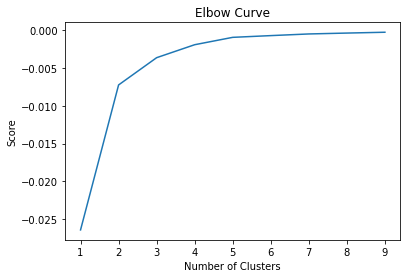

In [53]:
#elbow curve 
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = stores[['lat']]
X_axis = stores[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]


# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [54]:
kclusters = 5

In [55]:
kmeans = KMeans(n_clusters =kclusters, init ='k-means++')
kmeans.fit(stores[stores.columns[1:3]]) # Compute k-means clustering.
stores['cluster_label'] = kmeans.fit_predict(stores[stores.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(stores[stores.columns[1:3]]) # Labels of each point
stores.head(10)

,name,lat,lng,Type,cluster_label
0,The Little Beet,40.741086,-73.985333,Restaurant,4
1,The Little Beet,40.726851,-74.037911,Restaurant,3
2,The Little Beet,40.744036,-73.988810,Vegetarian / Vegan Restaurant,4
3,The Little Beet,40.760870,-73.982480,Restaurant,0
4,The Little Beet,40.757786,-73.974309,Restaurant,0
5,The Little Beet,40.751498,-73.977821,Vegetarian / Vegan Restaurant,4
6,The Little Beet,40.705075,-74.009160,Restaurant,2
8,The Little Beet,40.753955,-73.985541,Restaurant,4
0,Boqueria,40.724800,-74.002220,Tapas Restaurant,1
1,Boqueria,40.740200,-73.993770,Tapas Restaurant,4


In [56]:
cluster_map = folium.Map(location=[NYC_lat, NYC_lng], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stores['lat'], stores['lng'], stores['Type'], stores['cluster_label']):
    label = folium.Popup(str(poi))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
       
cluster_map

Now we can separate these clusters and see if there are any similarities between the numbers, and which type of stores populate which areas the most.



In [58]:
# merge sales data to our cluster dataframe
merged = pd.merge(
    stores,
    dfny,
    how="inner",
    on=None,
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [60]:
merged

,name,lat,lng,Type,cluster_label,Sales,YOY_Sales,Stores,YOY_Store_Growth,Unit_Volume,Franchise?
0,Bluestone Lane,40.706268,-74.011687,Café,2,48,33.0,48,37.1,1175,0
1,Bluestone Lane,40.700880,-73.988060,Café,2,48,33.0,48,37.1,1175,0
2,Bluestone Lane,40.730009,-74.002855,Café,1,48,33.0,48,37.1,1175,0
3,Bluestone Lane,40.730104,-73.990307,Coffee Shop,1,48,33.0,48,37.1,1175,0
4,Bluestone Lane,40.735808,-74.000863,Café,1,48,33.0,48,37.1,1175,0
5,Bluestone Lane,40.704599,-74.008748,Café,2,48,33.0,48,37.1,1175,0
6,Bluestone Lane,40.713360,-74.034026,Café,3,48,33.0,48,37.1,1175,0
7,Bluestone Lane,40.783757,-73.958526,Café,0,48,33.0,48,37.1,1175,0
8,Bluestone Lane,40.721860,-73.995703,Café,1,48,33.0,48,37.1,1175,0
9,Bluestone Lane,40.755470,-73.983178,Coffee Shop,4,48,33.0,48,37.1,1175,0


# Results

In [61]:
merged['cluster_label'].value_counts()


4    17
0    14
1    13
2     9
3     3
Name: cluster_label, dtype: int64

In [62]:
cluster_zero =  merged[merged['cluster_label']==0]
cluster_one =  merged[merged['cluster_label']==1]
cluster_two =  merged[merged['cluster_label']==2]
cluster_three =  merged[merged['cluster_label']==3]
cluster_four =  merged[merged['cluster_label']==4]


# Cluster Zero

In [64]:
zero_mean = cluster_zero['Unit_Volume'].mean()
print('The average unit volume for zone 0 is :')
zero_mean

The average unit volume for zone 0 is :


1630.0

In [65]:
cluster_zero['Type'].value_counts()


Juice Bar                        5
Coffee Shop                      2
Café                             2
Vegetarian / Vegan Restaurant    2
Restaurant                       2
Spanish Restaurant               1
Name: Type, dtype: int64

# Cluster One

In [66]:
one_mean = cluster_one['Unit_Volume'].mean()
print('The average unit volume for zone 1 is :')
one_mean

The average unit volume for zone 1 is :


1816.5384615384614

In [67]:
cluster_one['Type'].value_counts()


Café                             4
Juice Bar                        3
Vegetarian / Vegan Restaurant    3
Coffee Shop                      1
Bakery                           1
Tapas Restaurant                 1
Name: Type, dtype: int64

# Cluster Two

In [68]:
two_mean = cluster_two['Unit_Volume'].mean()
print('The average unit volume for zone 2 is :')
two_mean

The average unit volume for zone 2 is :


1288.3333333333333

In [69]:
cluster_two['Type'].value_counts()


Juice Bar                        4
Café                             3
Vegetarian / Vegan Restaurant    1
Restaurant                       1
Name: Type, dtype: int64

# Cluster Three

In [70]:
three_mean = cluster_three['Unit_Volume'].mean()
print('The average unit volume for zone 3 is :')
three_mean

The average unit volume for zone 3 is :


1526.6666666666667

In [71]:
cluster_three['Type'].value_counts()


Coffee Shop    1
Café           1
Restaurant     1
Name: Type, dtype: int64

# Cluster Four

In [72]:
four_mean = cluster_four['Unit_Volume'].mean()
print('The average unit volume for zone 4 is :')
four_mean

The average unit volume for zone 4 is :


1952.9411764705883

In [73]:
cluster_four['Type'].value_counts()


Coffee Shop                      4
Café                             4
Vegetarian / Vegan Restaurant    4
Tapas Restaurant                 2
Restaurant                       2
Juice Bar                        1
Name: Type, dtype: int64

Looks like there are advantages and disadvantages for each zone.  From this data we could consider Zone 0, which has significant volume and less cafes and coffee shops when compared to the other zones.  We could also consider looking deeper into zone 3, which has a limited data set but has decent volume and possibly the least saturated market.   